mounting the Google Drive

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


importing all the required libraries

In [92]:
# import all the necessary libraries here
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,balanced_accuracy_score,recall_score
import matplotlib.pyplot as plt
import graphviz
from IPython.display import Image,display_svg

Reading the given data into a dataframe

In [93]:
df = pd.read_csv('/content/drive/MyDrive/asssign2/dataset/decision-tree.csv')
attr_names = list(df.columns); attr_names.pop()
print(df.shape)

(768, 9)


In [94]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


splitting the data into training and validation

In [95]:
x_train=np.array(df.iloc[:,:8])
y_train=np.array(df.iloc[:,8])

In [96]:
x_train.shape

(768, 8)

In [97]:
y_train.shape

(768,)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2,random_state=42)

In [99]:
a=X_train.shape
c=X_test.shape
print("The size of train data is ",a)
print("The size of test data is ",c)

The size of train data is  (614, 8)
The size of test data is  (154, 8)


In [100]:
a=len(y_train)
c=len(y_test)
print("The size of train data is ",a)
print("The size of test data is ",c)

The size of train data is  614
The size of test data is  154


Implementation of entropy function

In [101]:
def entropy(targets):
    label_counts = Counter(targets)
    entropy = 0
    total_labels = len(targets)

    for label, count in label_counts.items():
        prob = count / total_labels
        entropy -= prob * np.log2(prob)

    return entropy

partititon of data into left subtree and right subtree

In [102]:
def partition(data,attr,target,value):
  m = data.shape[0]
  left_split = [data[i] for i in range(m) if data[i][attr]<value]
  left_split = np.array(left_split)
  targets_l = [target[i] for i in range(m) if data[i][attr]<value]
  targets_l = np.array(targets_l)
  right_split = [data[i]for i in range(m) if data[i][attr]>=value]
  right_split = np.array(right_split)
  targets_r = [target[i]for i in range(m) if data[i][attr]>=value]
  targets_r = np.array(targets_r)
  return left_split,right_split,targets_l,targets_r

Implementation of choosing the best attribute at a given node

In [103]:
def best_attr(data,target,attrs):
    total_entropy = entropy(target)
    m = data.shape[0]
    n = data.shape[1]
    entropies = [total_entropy for i in range(n) ]
    break_pt = [0 for i in range(n)]
    best_attr = attrs[0]

    for attr in attrs:
      attribute_values = list(set(data[:,attr]))
      attribute_values.sort()
      break_pt[attr] = attribute_values[0]-1
      for i in range(1,len(attribute_values)):
        curr_entropy= 0
        curr_val = (attribute_values[i-1]+attribute_values[i])/2
        l_data, r_data,l_targets,r_targets = partition(data,attr,target,curr_val)
        w1 = l_data.shape[0]/m
        w2 = r_data.shape[0]/m
        curr_entropy += w1*entropy(l_targets)
        curr_entropy += w2*entropy(r_targets)
        if(curr_entropy < entropies[attr]):
          break_pt[attr] = curr_val
          entropies[attr] = curr_entropy
      if entropies[attr] < entropies[best_attr]:
         best_attr = attr

    return best_attr,break_pt[best_attr],entropies[best_attr]

Definition of Node

In [104]:
class Node:
    def __init__(self,flag,label,attr,val,children,count):
        self.flag = flag
        self.label = label
        self.attr = attr
        self.val = val
        self.children = [0,0]
        self.count=count

Definition of Node Function and all the required functions for pruning and results

In [105]:
class DecisionTree:
  def __init__(self,dt):
    self.root = dt
  def decision(self,node,sample):
    if(node.flag==1):
      return node.label
    if(sample[node.attr]<node.val):
      return self.decision(node.children[0],sample)
    return self.decision(node.children[1],sample)

  def take_decision(self,data):
    pred=[]
    m = data.shape[0]
    for i in range(m):
      pred.append(self.decision(self.root,data[i]))
    return pred

  def copy_DT(self,node):
        newnode = Node(node.flag,node.label,node.attr,node.val,node.children,node.count)
        if(newnode.flag==0):
            newnode.children[0] = self.copy_DT(node.children[0])
            newnode.children[1] = self.copy_DT(node.children[1])
        return newnode

  def copy_dt(self):
        newdt = DecisionTree(self.copy_DT(self.root))
        return newdt

  def getAccuracy(self,data_test,true_data):
        prediction = self.take_decision(data_test)
        return balanced_accuracy_score(true_data,prediction)

  def getMacroPrecision(self,data_test,true_data):
        prediction = self.take_decision(data_test)
        return precision_score(true_data,prediction,average="macro")

  def getMacroRecall(self,data_test,true_data):
        prediction = self.take_decision(data_test)
        return recall_score(true_data,prediction,average="macro")

  def printMetrics(self,data_test,true_data,name):
        metrics = [self.getAccuracy(data_test,true_data),self.getMacroPrecision(data_test,true_data),self.getMacroRecall(data_test,true_data)]
        print(f"---> {name} <---")
        print(f"Mean Macro Accuracy: {metrics[0]}")
        print(f"Macro Precision: {metrics[1]}")
        print(f"Macro Recall: {metrics[2]}")


  def _maxDepth(self,node,depth):
        if(node.flag==1):
            return depth
        return max(self._maxDepth(node.children[0],depth+1),self._maxDepth(node.children[1],depth+1))

  def maxDepth(self):
        return self._maxDepth(self.root,1)

  def _visualise(self,dot,node,count,parent):
        node_count = count[0]
        count[0] += 1
        if(node.flag==0):
            dot.node(str(node_count),f"{attr_names[node.attr]}\n{node.val}")
            dot.edge(str(parent),str(node_count))
            self._visualise(dot,node.children[0],count,node_count)
            self._visualise(dot,node.children[1],count,node_count)
        else:
            dot.node(str(node_count),f"Label = {node.label}")
            dot.edge(str(parent),str(node_count))

  def visualise(self,name):
        count =[1]
        dot = graphviz.Digraph(name, comment=name)
        dot.node('0',f"Data")
        self._visualise(dot,self.root,count,0)
        return dot

  def visualiseAndSave(self,name):
        dot = self.visualise(name)
        dot.render(name, format="png", cleanup=True)
        print(f"Saved as ",end="")
        image_path = f'./{name}.png'
        print(image_path)
        return dot




Creating the tree recursively

In [106]:

def create_tree(data,target,attributes):
  curr_entropy = entropy(target)
  best_attribute,brk_pt,new_entropy = best_attr(data,target,attributes)
  l_data,r_data,l_target,r_target = partition(data,best_attribute,target,brk_pt)
  new_attributes=list(attributes)
  counter = Counter(target)
  count=[Counter[0],Counter[1]]
  if counter[0]>counter[1]:
    max = 0
  else :
    max = 1
  dt = Node(1,max,best_attribute,brk_pt,[0,0],count)
  if(new_entropy<curr_entropy and data.shape[0]>=10 and len(new_attributes)>0):
    dt.flag=0
    dt.children[0] = create_tree(l_data,l_target,attributes)
    dt.children[1] = create_tree(r_data,r_target,attributes)
  return dt

creating the instance of root  and decision tree

In [107]:
attributes = [0,1,2,3,4,5,6,7]
root = create_tree(X_train, y_train, attributes)
Dec_tree = DecisionTree(root)

metrics on test dataset before pruning

In [108]:
Dec_tree.printMetrics(X_test,y_test,"testing data")

---> testing data <---
Mean Macro Accuracy: 0.7202020202020202
Macro Precision: 0.7125886524822695
Macro Recall: 0.7202020202020202


visulaisation of decision tree before pruning

Saved as ./Decision_Tree.png
Trained Decision Tree


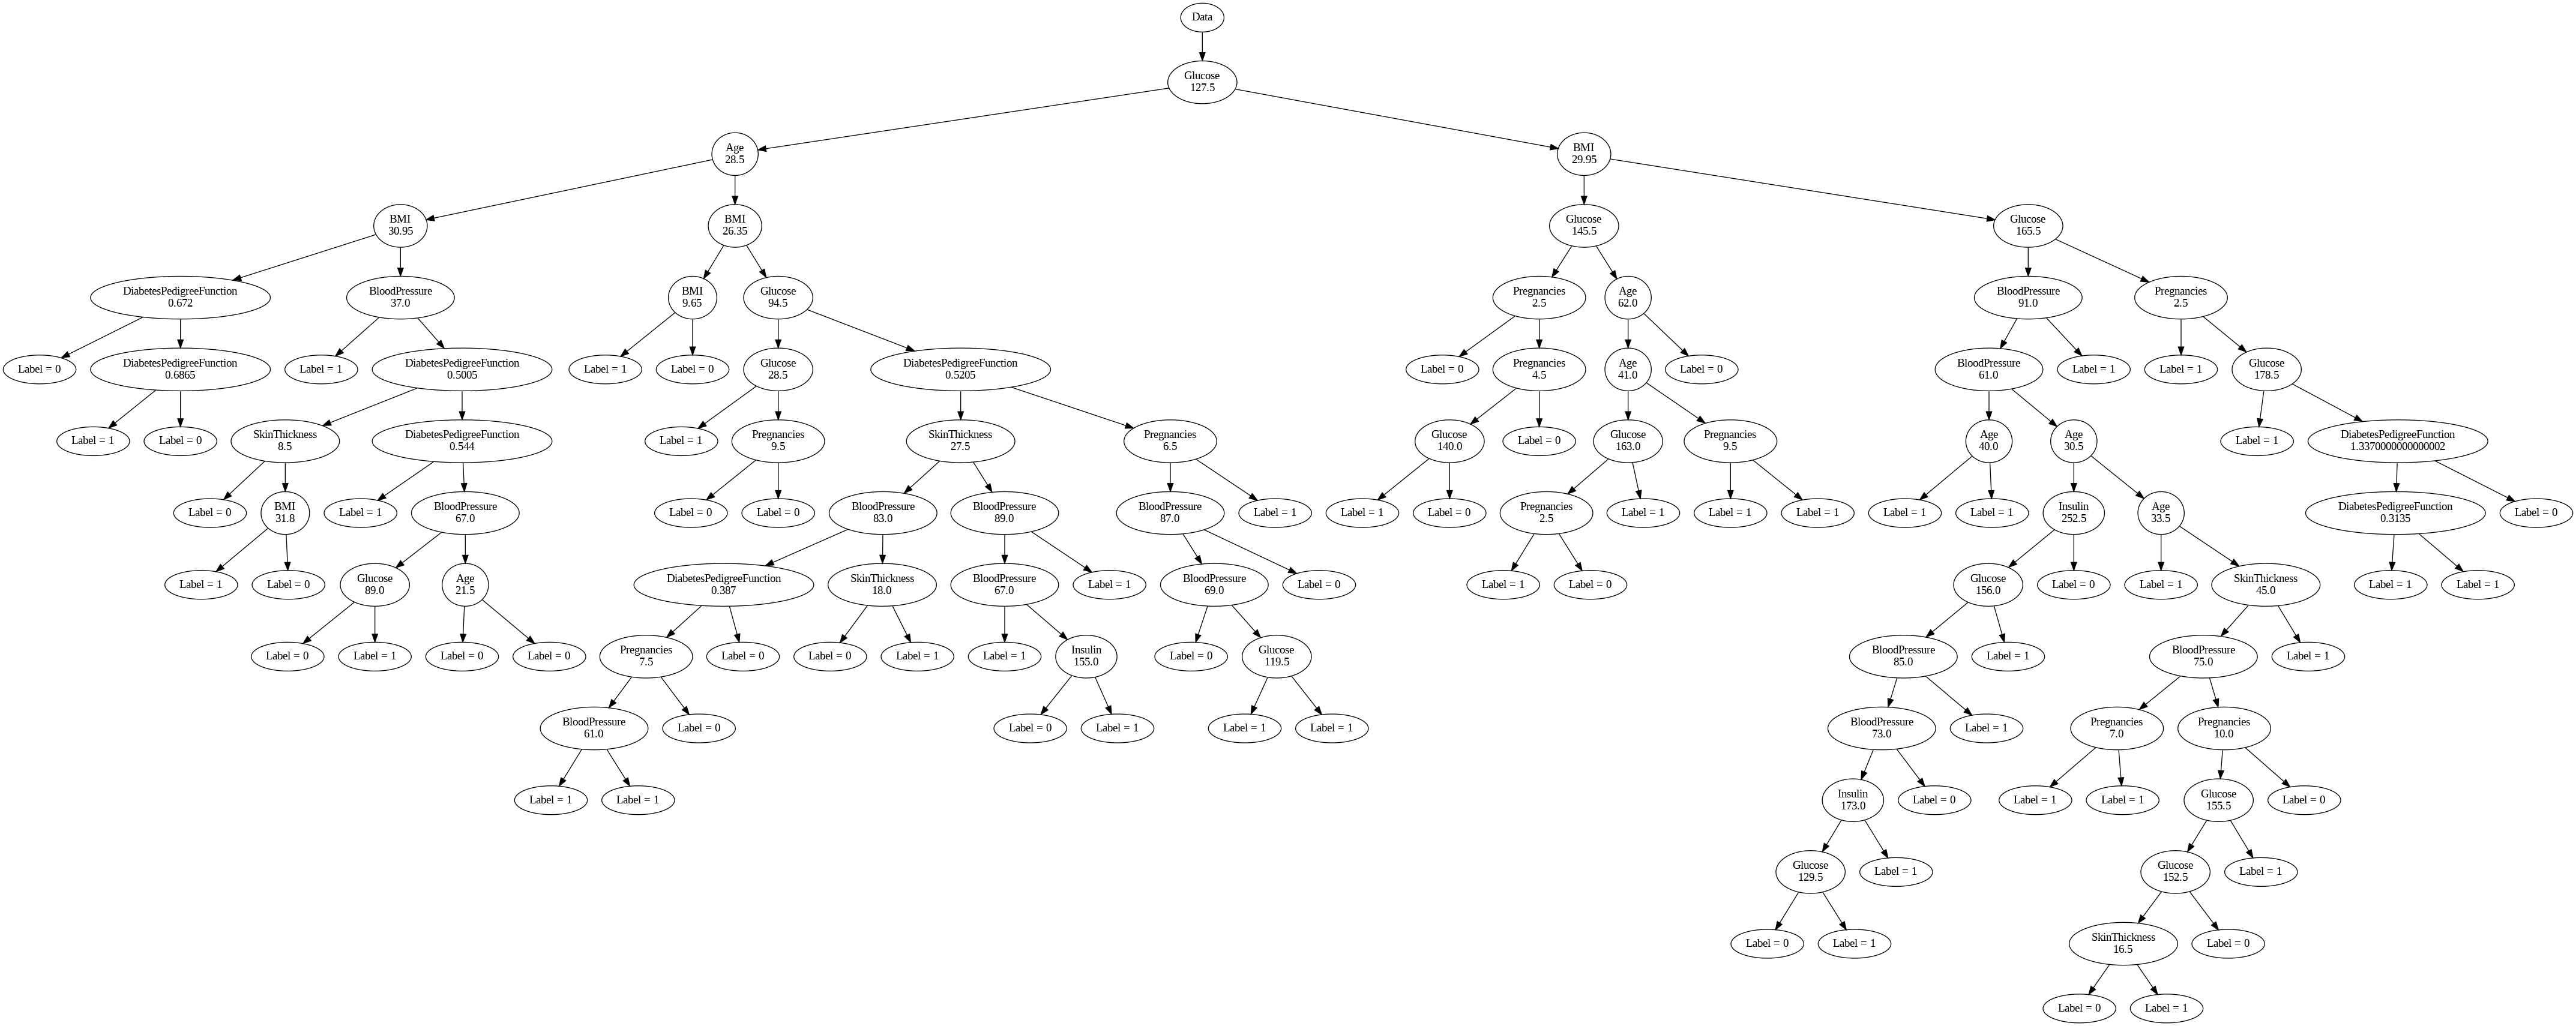

In [109]:
dot = Dec_tree.visualiseAndSave("Decision_Tree")
print("Trained Decision Tree")
Image(filename="./Decision_Tree.png")

implementation of pruning for a node

In [110]:

def prune(curr_dt,node,depth,depth_limit):
    if(node.flag==1):
        return

    if(depth<depth_limit):
        prune(curr_dt,node.children[0],depth+1,depth_limit)
        prune(curr_dt,node.children[1],depth+1,depth_limit)
        return

    node_copy = Node(node.flag,node.label,node.attr,node.val,node.children,node.count)
    node_copy.children[0] = node.children[0]; node_copy.children[1] = node.children[1]


    accuracy_bef_pruning = curr_dt.getAccuracy(X_test,y_test)

    node.flag = 1
    node.children[0] = node.children[1] = None

    accuracy_after_pruning = [0,0]
    node.label = 0
    accuracy_after_pruning[0] = curr_dt.getAccuracy(X_test,y_test)

    node.label = 1
    accuracy_after_pruning[1] = curr_dt.getAccuracy(X_test,y_test)

    best_label = 0 if(accuracy_after_pruning[0]>accuracy_after_pruning[1]) else 1

    if(accuracy_after_pruning[best_label] >= accuracy_bef_pruning):
        node.label = best_label
        return

    node.flag = node_copy.flag
    node.label = node_copy.label
    node.children[0] = node_copy.children[0]; node.children[1] = node_copy.children[1]
    prune(curr_dt,node.children[0],depth+1,depth_limit)
    prune(curr_dt,node.children[1],depth+1,depth_limit)
    return


setting the depth limits for getting the best pruning result

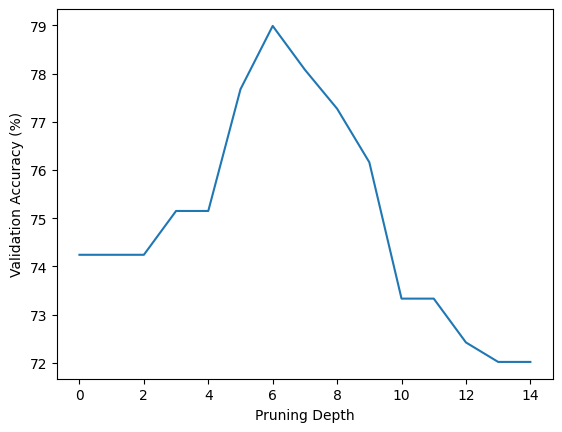

Best Accuracy Achieved by pruning nodes with depth between "6" and "14"
Best Possible Accuracy: 0.7898989898989899


In [111]:
x_points = []
y_points = []
decision_trees = []
best_depth = 0

max_Depth = Dec_tree.maxDepth()

for depth_limit in range(0,max_Depth+1):
    newdt = Dec_tree.copy_dt()
    prune(newdt,newdt.root,0,depth_limit)
    x_points.append(depth_limit)
    prediction = newdt.take_decision(X_test)
    y_points.append(balanced_accuracy_score(y_test,prediction))
    best_depth = depth_limit if(y_points[depth_limit] > y_points[best_depth]) else best_depth

    decision_trees.append(newdt.visualise(f"Decision_Tree[{depth_limit}]"))



y_points = [i*100 for i in y_points]
plt.plot(x_points,y_points)
plt.xlabel("Pruning Depth")
plt.ylabel("Validation Accuracy (%)")
plt.show()

pruned_dt = Dec_tree.copy_dt()
prune(pruned_dt,pruned_dt.root,0,best_depth)
print(f"Best Accuracy Achieved by pruning nodes with depth between \"{best_depth}\" and \"{max_Depth}\"")
print("Best Possible Accuracy:",pruned_dt.getAccuracy(X_test,y_test))

visualisation of pruned Decision tree

Saved as ./Pruned_DT.png
Best Accuracy Decision Tree


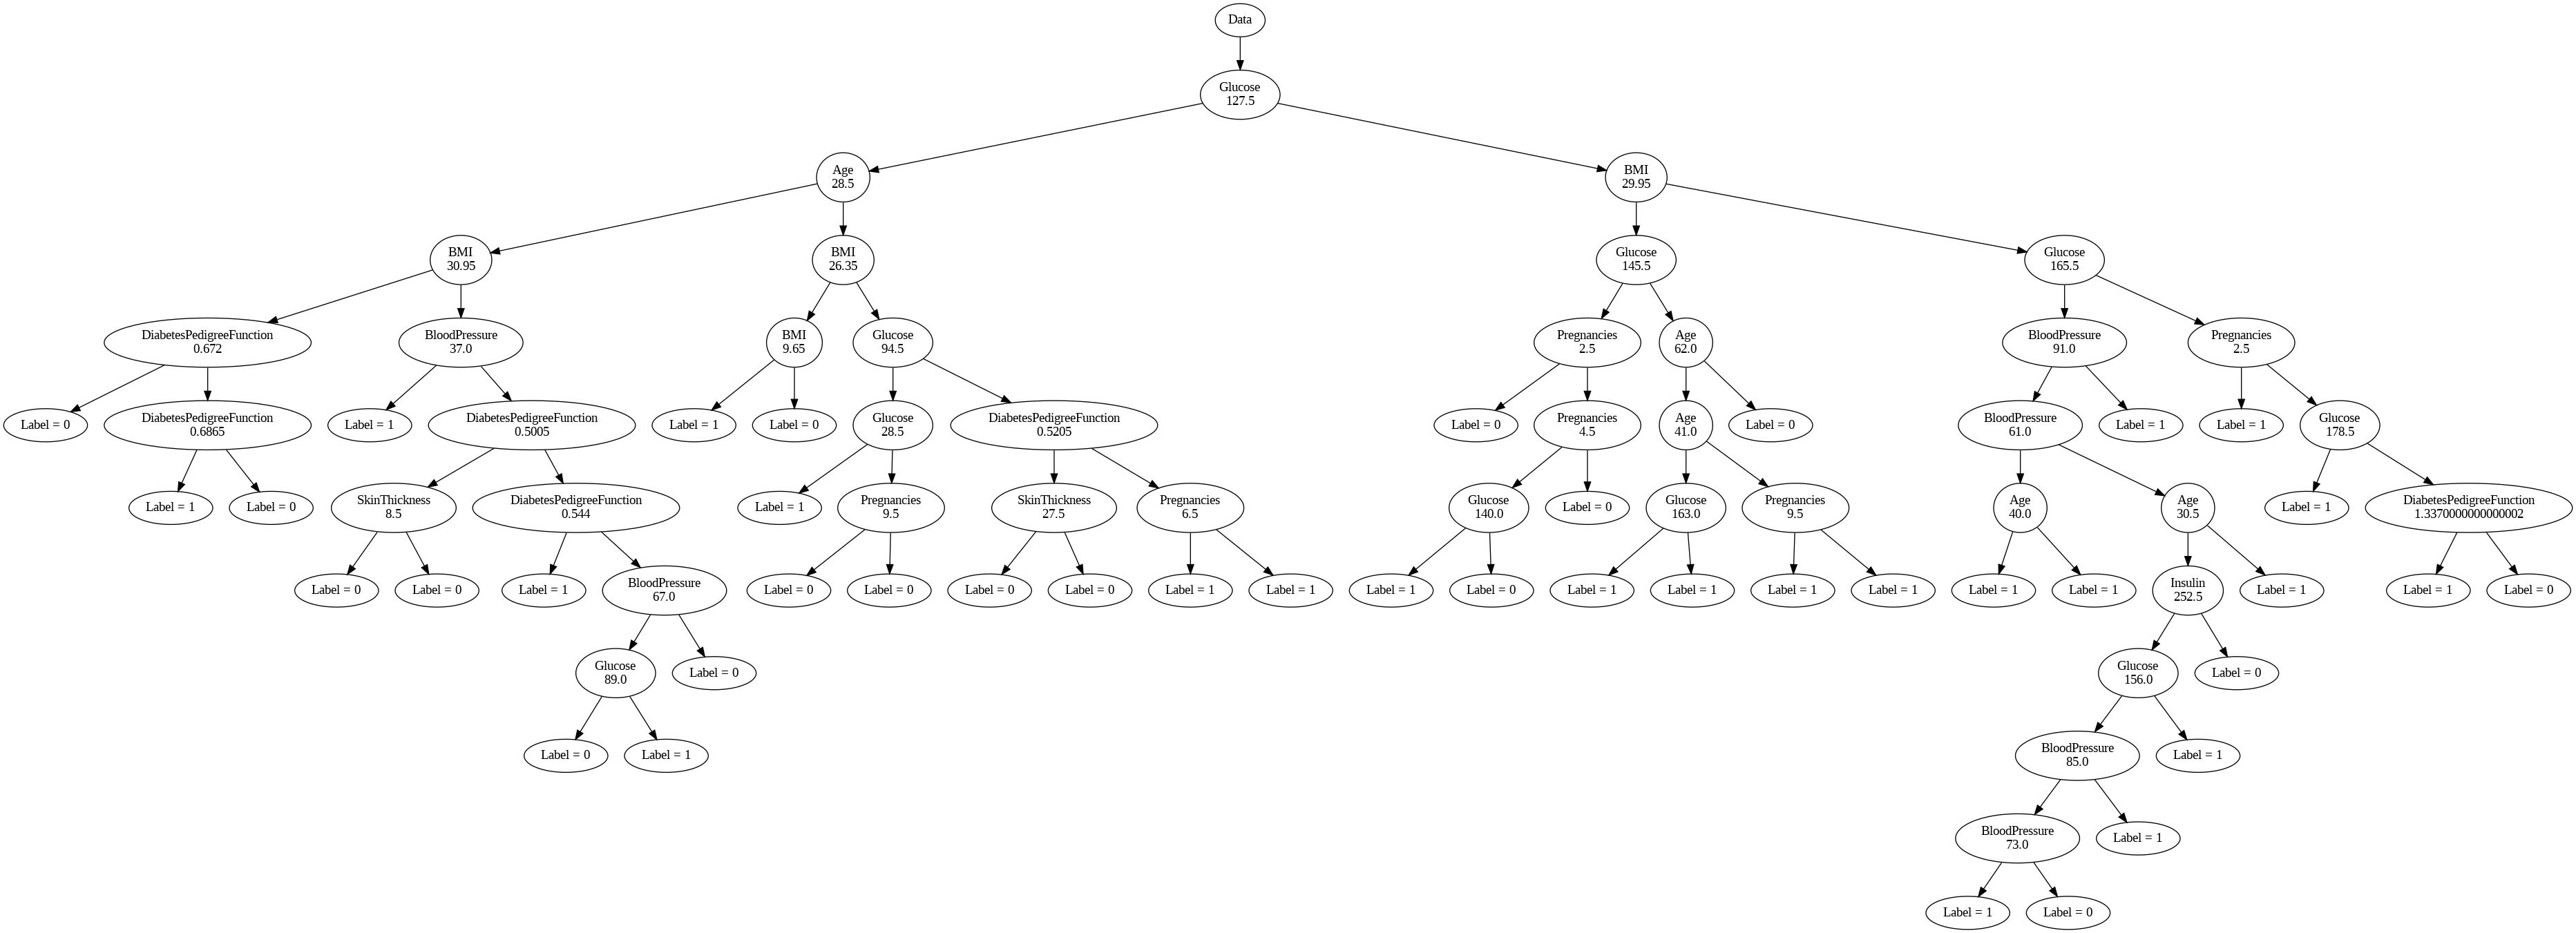

In [112]:
dot = pruned_dt.visualiseAndSave("Pruned_DT")
print("Best Accuracy Decision Tree")
Image(filename='./Pruned_DT.png')

Metrics for pruned decision tree

In [90]:
pruned_dt.printMetrics(X_test,y_test,"Pruned Tree Metrics")

---> Pruned Tree Metrics <---
Mean Macro Accuracy: 0.7898989898989899
Macro Precision: 0.7753357753357754
Macro Recall: 0.7898989898989899
